In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import random
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

# Task 1

#### 데이터 준비하기

In [2]:
train = pd.read_csv('./ua.base', sep='\t',header=None,names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv('./ua.test', sep='\t',header=None,names=['user', 'movie', 'rating', 'timestamp'])
train.head()
# train = pd.read_csv('./ua.base', sep='\t',header=None)

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [3]:
test.head()

,user,movie,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


In [4]:
# User와 movie 값이 1부터 시작하기 때문에 0부터 시작하도록 하기 위해 1을 빼주는 작업을 수행 
# train data에서 movie id값을 1씩 빼주도록 하겠다.
# User도 0부터 시작하기 위해 1을 빼주겠다.
train.user = train.user - 1
train.movie = train.movie - 1
test.user = test.user - 1
test.movie = test.movie - 1
train.head()

,user,movie,rating,timestamp
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712


In [5]:
test.head()

,user,movie,rating,timestamp
0,0,19,4,887431883
1,0,32,4,878542699
2,0,60,4,878542420
3,0,116,3,874965739
4,0,154,2,878542201


In [6]:
# 데이터 형태 변환 
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [7]:
item = pd.read_csv('./u.item', sep='|',header=None,engine='python').iloc[:,:2]
item = item.rename(columns={0:'id',1:'Title'})
# item의 id가 1부터 시작하기 때문에 1을 빼주어서 작업을 수행할 예정
item.id = item.id-1
item.head()

,id,Title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


# Task 2

#### Latent Factor 모델을 이용하여 학습하기

In [8]:
rank = 5
numItems = items.max() + 1 
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

# # Bias 추가
lambda1 = 0.00001
lambda2 = 0.00001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

# cost에 regularization 추가 
lambda3 = 0.00001
lambda4 = 0.00001
X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.01)
for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = torch.sqrt(F.mse_loss(hypothesis ,ratings))
    loss = cost + lambda3 * torch.sum(P ** 2) + lambda4 * torch.sum(Q ** 2) + lambda1 * torch.sum(bias_item ** 2) + lambda2 * torch.sum(bias_user ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    X.append(epoch)
    Y.append(cost)
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
        cost_test = torch.sqrt(F.mse_loss(hypo_test, ratings_test))
        Y_test.append(cost_test)
    if epoch % 100 == 0:
        print("epoch: {}, train_cost: {:.6f}, test_cost: {:.6f}" .format(epoch, cost.item(),cost_test.item()))

epoch: 0, train_cost: 2.904232, test_cost: 2.859254
epoch: 100, train_cost: 1.191130, test_cost: 1.317634
epoch: 200, train_cost: 0.884298, test_cost: 1.045046
epoch: 300, train_cost: 0.835353, test_cost: 1.016178
epoch: 400, train_cost: 0.808443, test_cost: 1.005378
epoch: 500, train_cost: 0.793342, test_cost: 0.999918
epoch: 600, train_cost: 0.783233, test_cost: 0.994829
epoch: 700, train_cost: 0.776224, test_cost: 0.988540
epoch: 800, train_cost: 0.771412, test_cost: 0.982303
epoch: 900, train_cost: 0.768397, test_cost: 0.978660
epoch: 1000, train_cost: 0.766624, test_cost: 0.976569


# Task 3

#### 13번 User에게 추천하기 (knn search)

In [9]:
P.shape, Q.shape, item.shape

(torch.Size([1682, 5]), torch.Size([943, 5]), (1682, 2))

In [10]:
# Task 3-1
movie_list = torch.argsort(torch.sum(P * Q[12], dim=1) + mean + bias_item + bias_user[12],descending=True).tolist()[:20]
item.loc[movie_list]

,id,Title
640,640,Paths of Glory (1957)
198,198,"Bridge on the River Kwai, The (1957)"
525,525,Ben-Hur (1959)
1141,1141,When We Were Kings (1996)
1128,1128,Chungking Express (1994)
1642,1642,Angel Baby (1995)
512,512,"Third Man, The (1949)"
168,168,"Wrong Trousers, The (1993)"
49,49,Star Wars (1977)
1396,1396,Of Human Bondage (1934)


In [11]:
def cosine_similar(x,y):
    dot = sum(a*b for a,b in zip(x,y))
    norm_a = sum(a*a for a in x) ** 0.5
    norm_b = sum(b*b for b in y) ** 0.5
    
    return dot / (norm_a *norm_b)

In [12]:
# Task 3-2
cosine = []
for i in range(len(P)):
    cosine.append(cosine_similar(P[i],Q[12]).tolist())
cosine = np.array(cosine)
cos_movie_list = np.argsort(cosine)[::-1].tolist()[:20]
item.loc[cos_movie_list]

,id,Title
813,813,"Great Day in Harlem, A (1994)"
490,490,"Adventures of Robin Hood, The (1938)"
198,198,"Bridge on the River Kwai, The (1957)"
1396,1396,Of Human Bondage (1934)
56,56,Priest (1994)
525,525,Ben-Hur (1959)
527,527,"Killing Fields, The (1984)"
954,954,Before Sunrise (1995)
483,483,"Maltese Falcon, The (1941)"
835,835,Ninotchka (1939)


# Task 4

#### 영화 클러스터링하기 (k-means clustering)

In [13]:
def cosine_similar(x,y):
    dot = sum(a*b for a,b in zip(x,y))
    norm_a = sum(a*a for a in x) ** 0.5
    norm_b = sum(b*b for b in y) ** 0.5
    
    return dot / (norm_a *norm_b)

def assign(p,centroids):
    max_dist_centroids_idx = -1
    max_dist = -10
    for i, c in enumerate(centroids):
        try:
            dist = cosine_similar(c, p)
        except:
            dist = cosine_similar(c[0],p)
        if max_dist < dist:
            max_dist_centroids_idx = i
            max_dist = dist
                
    return max_dist_centroids_idx

def compute_centroids(assignments, points, k):
    clusters = [[] for _ in range(k)]
    for a,p in zip(assignments,points):
        clusters[a].append(p)
    
    new_cluster = [np.mean(c,axis=0).tolist() for c in clusters]
    
    for i in range(len(new_cluster)):
        try:
            sum(pd.isna(new_cluster[i]))
                
        except:
            new_cluster[i] = random.choices(points,k=1)
            
    return new_cluster

def kmeans(k,points):
    
    pre_assignments = []
    
    # 1. random으로 centroid 선택 
    centroids = random.choices(points,k=k)
    
    for epoch in range(10):
        
        assignments = []
#         for p in points:
#             min_dist_centroids_idx = assign(p,centroids)
#             assignments.append(min_dist_centroids_idx)
        # 2. 각 점마다 가장 가까운 centroid의 cluster에 점 할당 
    
        assignments = [assign(p,centroids) for p in points]
        
        # 3. cluster의 평균을 구해서 centorid 업데이트 
        centroids = compute_centroids(assignments, points,k)
        
        # 4. cluster가 변했는지 확인하고, 변했으면 계속, 변하지 않았으면 멈춤 
        if assignments == pre_assignments:
            break
        pre_assignments = assignments
        
    return assignments, centroids

In [14]:
cost = []
item_data = P.tolist()
length = len(item_data)
for i in tqdm(range(1,41)):
    cost_val = 0
    a,c = kmeans(i,item_data)
    for j in range(length):
        cost_val += 1 - cosine_similar(c[a[j]],item_data[j])
    cost.append(cost_val)

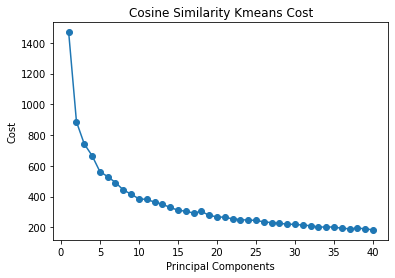

In [15]:
plt.title("Cosine Similarity Kmeans Cost")
plt.xlabel("Principal Components")
plt.ylabel("Cost")
plt.plot(range(1,41), cost, "o-")
plt.show()

12 군집만 남기는게 좋을것 같다.

# Task 5

#### 차원 축소 및 시각화 (PCA)

### 실제 추정한 Rating Matrix를 만들기 위한 작업을 수행 

In [16]:
Z = torch.cat([P,Q])
Z.shape

torch.Size([2625, 5])

In [17]:
item_length = P.shape[0]
user_length = Q.shape[0]

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,random_state=701)
new_Z = pca.fit_transform(Z.tolist())
new_Z.shape

(2625, 2)

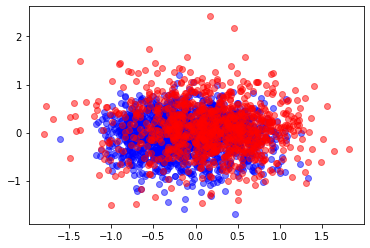

In [19]:
plt.scatter(new_Z[:item_length,0],new_Z[:item_length,1], c = 'b',alpha=0.5)
plt.scatter(new_Z[item_length:,0],new_Z[item_length:,1], c = 'r', alpha=0.5)

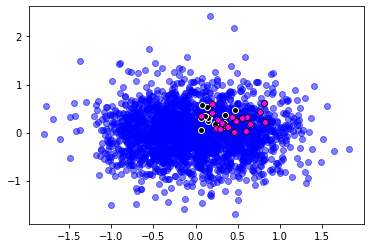

In [20]:
plt.scatter(new_Z[:item_length,0],new_Z[:item_length,1], c = 'b',alpha=0.5)
plt.scatter(new_Z[item_length:,0],new_Z[item_length:,1], c = 'b', alpha=0.5)
plt.scatter(new_Z[cos_movie_list,0],new_Z[cos_movie_list,1], c='black',alpha=1,edgecolors='white')
plt.scatter(new_Z[movie_list,0],new_Z[movie_list,1], c='magenta',alpha=1,edgecolors='black')

In [25]:
item_data = P.tolist()
a,c = kmeans(12,item_data)
cluster = np.array(a)
new_P = new_Z[:item_length,:]

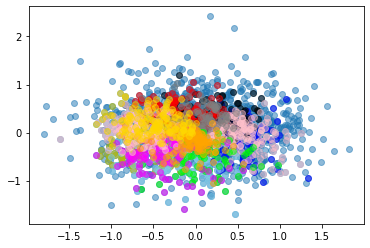

In [26]:
plt.scatter(new_Z[:,0],new_Z[:,1],alpha=0.5)
plt.scatter(new_P[cluster == 0,0],new_P[cluster == 0,1], c = 'b', alpha=0.5)
plt.scatter(new_P[cluster == 1,0],new_P[cluster == 1,1], c = 'y', alpha=0.5)
plt.scatter(new_P[cluster == 2,0],new_P[cluster == 2,1], c = 'k', alpha=0.5)
plt.scatter(new_P[cluster == 3,0],new_P[cluster == 3,1], c = 'r', alpha=0.5)
plt.scatter(new_P[cluster == 4,0],new_P[cluster == 4,1], c = 'pink', alpha=0.5)
plt.scatter(new_P[cluster == 5,0],new_P[cluster == 5,1], c = 'skyblue', alpha=0.5)
plt.scatter(new_P[cluster == 6,0],new_P[cluster == 6,1], c = 'gray', alpha=0.5)
plt.scatter(new_P[cluster == 7,0],new_P[cluster == 7,1], c = 'lime', alpha=0.5)
plt.scatter(new_P[cluster == 8,0],new_P[cluster == 8,1], c = 'magenta', alpha=0.5)
plt.scatter(new_P[cluster == 9,0],new_P[cluster == 9,1], c = 'pink', alpha=0.5)
plt.scatter(new_P[cluster == 10,0],new_P[cluster == 10,1], c = 'orange', alpha=0.5)
plt.scatter(new_P[cluster == 11,0],new_P[cluster == 11,1], c = 'gold', alpha=0.5)